Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

### Importing all the important libraries

In [21]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from glob import glob
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import BatchNormalization
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

tf.get_logger().setLevel('ERROR')

In [2]:
## Mounting the google drive:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


The dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images

data_dir_train = pathlib.Path("/content/gdrive/My Drive/Data/Train")
data_dir_test = pathlib.Path("/content/gdrive/My Drive/Data/Test")

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Using 80% of the images for training, and 20% for validation.

In [6]:
## Train dataset 
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Visualize one instance of all the nine classes present in the dataset

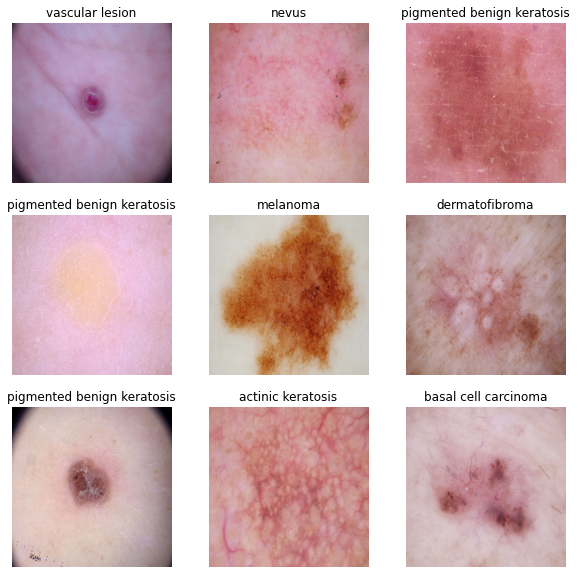

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create CNN model to accurately detect 9 classes present in the dataset.


In [14]:
input_shape = (180,180,3)
num_classes = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))

model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))

model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

### Compile the model


In [15]:
optimizer = 'adam'

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [16]:
# View the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper_12 (ModuleWr  (None, 180, 180, 32)     2432      
 apper)                                                          
                                                                 
 module_wrapper_13 (ModuleWr  (None, 180, 180, 32)     25632     
 apper)                                                          
                                                                 
 module_wrapper_14 (ModuleWr  (None, 90, 90, 32)       0         
 apper)                                                          
                                                                 
 module_wrapper_15 (ModuleWr  (None, 90, 90, 32)       25632     
 apper)                                               

### Train the model

In [17]:
epochs = 20
batch_size = 32

history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 325s 1s/step - loss: 2.0902 - accuracy: 0.1897 - val_loss: 2.0373 - val_accuracy: 0.2371
Epoch 2/20
56/56 [==============================] - 5s 92ms/step - loss: 2.0183 - accuracy: 0.2015 - val_loss: 1.9507 - val_accuracy: 0.3087
Epoch 3/20
56/56 [==============================] - 5s 92ms/step - loss: 1.9206 - accuracy: 0.2556 - val_loss: 1.8541 - val_accuracy: 0.3333
Epoch 4/20
56/56 [==============================] - 5s 93ms/step - loss: 1.8761 - accuracy: 0.2874 - val_loss: 1.8534 - val_accuracy: 0.2975
Epoch 5/20
56/56 [==============================] - 5s 92ms/step - loss: 1.7536 - accuracy: 0.3571 - val_loss: 1.6186 - val_accuracy: 0.4228
Epoch 6/20
56/56 [==============================] - 5s 92ms/step - loss: 1.6273 - accuracy: 0.4118 - val_loss: 1.5792 - val_accuracy: 0.4161
Epoch 7/20
56/56 [==============================] - 5s 91ms/step - loss: 1.5616 - accuracy: 0.4481 - val_loss: 1.4968 - val_accuracy: 0.4653
Epoch 8/20
56

### Visualizing training results

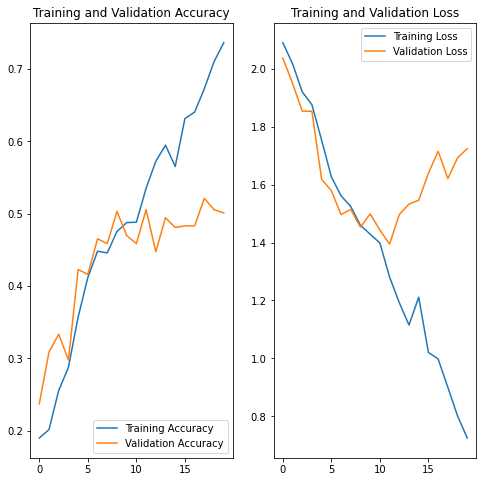

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model Overfit or Underfit?

In [19]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)


14/14 [==============================] - 0s 21ms/step - loss: 1.7244 - accuracy: 0.5011
Accuracy:  0.8102678656578064
Validation Accuracy:  0.501118540763855
Loss:  0.5461931824684143
Validation Loss 1.7243983745574951


#### Observations:

1.   The validation loss is significantly higher than training loss, which shows evidence of overfitting
2.   The training accuracy is comparatively better than the validation accuracy which also signifies that model is overfitting

We need to choose the right data augmentation strategy to avoid overfitting.


In [22]:
data_augument = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

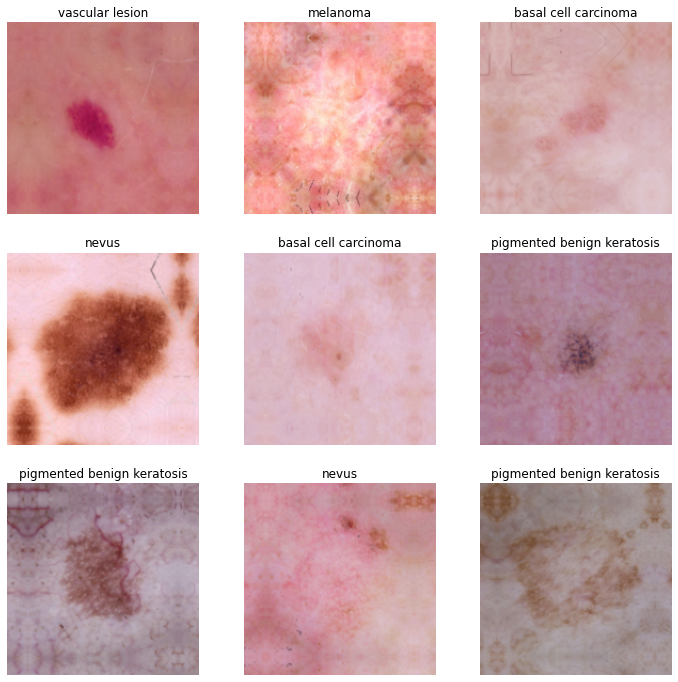

In [23]:
# visualize how augmentation strategy works for one instance of training image.
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [24]:

from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ data_augument,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))


### Compiling the model

In [25]:

optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [26]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001)

### Training the model

In [27]:
## Train model for 20 epochs
epochs = 20
batch_size = 32
history = model.fit(train_ds,epochs = epochs, verbose = 1, validation_data=val_ds , callbacks=[learning_rate_reduction])


Epoch 1/20
56/56 [==============================] - 19s 268ms/step - loss: 2.0321 - accuracy: 0.1987 - val_loss: 2.0568 - val_accuracy: 0.2215 - lr: 0.0010
Epoch 2/20
56/56 [==============================] - 15s 261ms/step - loss: 1.8610 - accuracy: 0.3198 - val_loss: 1.9763 - val_accuracy: 0.3043 - lr: 0.0010
Epoch 3/20
56/56 [==============================] - 15s 260ms/step - loss: 1.9005 - accuracy: 0.3114 - val_loss: 1.8333 - val_accuracy: 0.2416 - lr: 0.0010
Epoch 4/20
56/56 [==============================] - 15s 260ms/step - loss: 1.6614 - accuracy: 0.4090 - val_loss: 1.7514 - val_accuracy: 0.4251 - lr: 0.0010
Epoch 5/20
56/56 [==============================] - 14s 258ms/step - loss: 1.5992 - accuracy: 0.4302 - val_loss: 1.6200 - val_accuracy: 0.4452 - lr: 0.0010
Epoch 6/20
56/56 [==============================] - 15s 260ms/step - loss: 1.5662 - accuracy: 0.4554 - val_loss: 1.6037 - val_accuracy: 0.4430 - lr: 0.0010
Epoch 7/20
56/56 [==============================] - 15s 265ms/st

### Visualizing the results

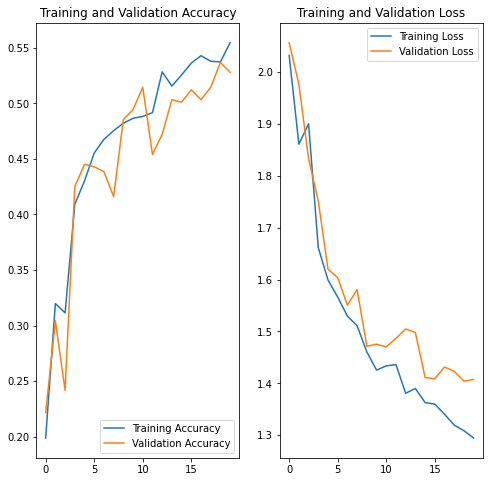

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [30]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

14/14 [==============================] - 0s 23ms/step - loss: 1.4073 - accuracy: 0.5280
Accuracy:  0.5334821343421936
Validation Accuracy:  0.5279642343521118
Loss:  1.3528465032577515
Validation Loss 1.4073410034179688


#### Observations:

1.   The difference between the validation loss and training loss has reduced thereby reducing the problem of overfitting. The model is being regularized  there by showing an increase in the training loss and decrease in the validation loss.
2.   The training accuracy has reduced as compared to previous model there by showing the slight underfitting.

#### Let's Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [31]:
path_list=[]
lesion_list=[]
for i in class_names:
      
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/My Drive/Data/Train/actinic ke...,actinic keratosis
1,/content/gdrive/My Drive/Data/Train/actinic ke...,actinic keratosis
2,/content/gdrive/My Drive/Data/Train/actinic ke...,actinic keratosis
3,/content/gdrive/My Drive/Data/Train/actinic ke...,actinic keratosis
4,/content/gdrive/My Drive/Data/Train/actinic ke...,actinic keratosis
...,...,...
2234,/content/gdrive/My Drive/Data/Train/vascular l...,vascular lesion
2235,/content/gdrive/My Drive/Data/Train/vascular l...,vascular lesion
2236,/content/gdrive/My Drive/Data/Train/vascular l...,vascular lesion
2237,/content/gdrive/My Drive/Data/Train/vascular l...,vascular lesion


In [32]:
original_df['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

<BarContainer object of 9 artists>

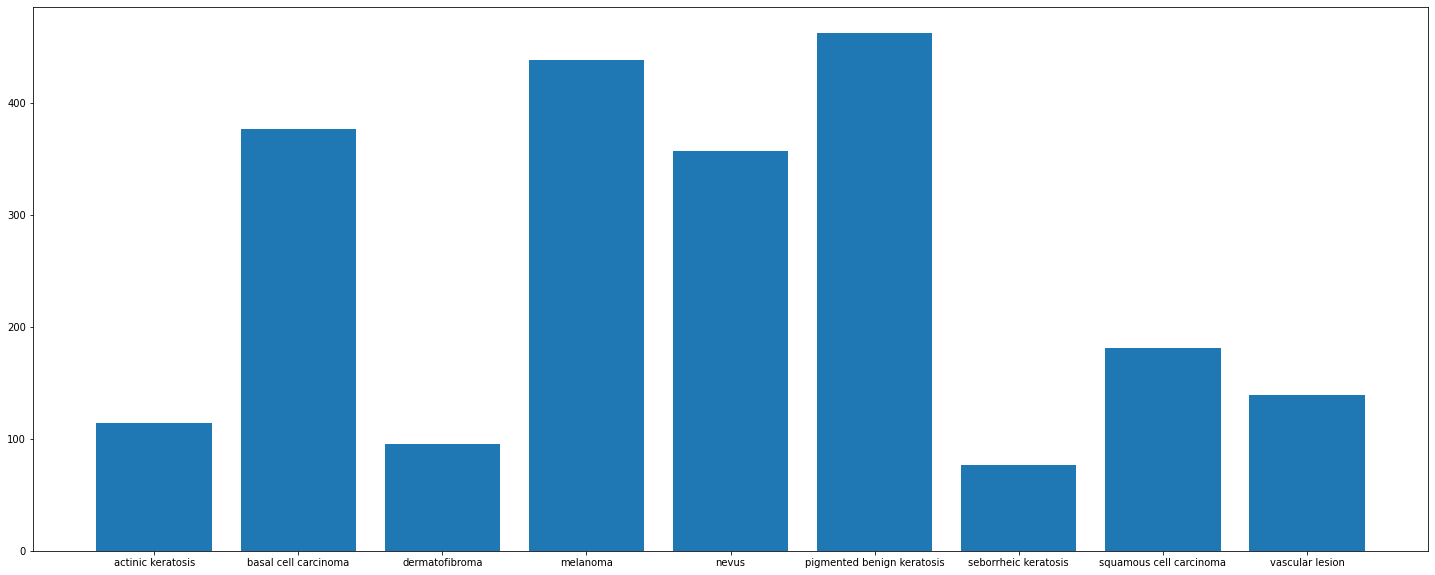

In [36]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?  - **Actinic Keratosos and Seborrheic keratosis**
#### - Which classes dominate the data in terms proportionate number of samples? - **Pigmented benign keratosis** dominates the data of count more than 100 in training set


#### Let's rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [37]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [38]:
path_to_training_dataset="/content/gdrive/My Drive/Data/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/Data/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FECB2A2E5E0>: 100%|██████████| 500/500 [00:24<00:00, 20.64 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/Data/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FECB26253D0>: 100%|██████████| 500/500 [00:20<00:00, 24.74 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/Data/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FECB26EC0D0>: 100%|██████████| 500/500 [00:19<00:00, 25.45 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/Data/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7FECA886EDF0>: 100%|██████████| 500/500 [01:49<00:00,  4.59 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/Data/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7FECB2EBEE80>: 100%|██████████| 500/500 [01:23<00:00,  5.96 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/Data/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FECC2D24B50>: 100%|██████████| 500/500 [00:21<00:00, 23.42 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/Data/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FECB2AA80A0>: 100%|██████████| 500/500 [00:47<00:00, 10.44 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/Data/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FED3832D610>: 100%|██████████| 500/500 [00:21<00:00, 23.53 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/Data/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FECA8845610>: 100%|██████████| 500/500 [00:20<00:00, 24.91 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [39]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [40]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/My Drive/Data/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0028659.jpg_f7b8459f-8e13-47d6-8463-cc3a592f19a2.jpg',
 '/content/gdrive/My Drive/Data/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029573.jpg_56c0af72-d458-4415-8db9-bdb8d9052bf6.jpg',
 '/content/gdrive/My Drive/Data/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0032349.jpg_5c622917-b5bf-4702-966c-7b09b8656e4a.jpg',
 '/content/gdrive/My Drive/Data/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027708.jpg_0916fee4-4f2f-4b6f-8c2f-00da9befcd50.jpg',
 '/content/gdrive/My Drive/Data/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030714.jpg_7bf16dc7-335c-44ee-9690-4b290b96d76d.jpg',
 '/content/gdrive/My Drive/Data/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0028499.jpg_a2c24d76-0846-42e5-80d2-4d5505216075.jpg',
 '/content/gdrive/My Drive/D

In [42]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carc

In [43]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [44]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [45]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [46]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [47]:
data_dir_train="/content/gdrive/My Drive/Data/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [48]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Create model (make sure to include normalization)

In [49]:
num_classes = 9
model = Sequential([ 
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height,img_width,3))
      
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

#### Compile model

In [50]:
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [51]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001)

#### Let's train the model

In [52]:
epochs = 30
history = model.fit(train_ds, epochs = epochs, verbose = 1, validation_data=val_ds , callbacks=[learning_rate_reduction])

Epoch 1/30
169/169 [==============================] - 38s 214ms/step - loss: 2.1967 - accuracy: 0.1350 - val_loss: 2.1930 - val_accuracy: 0.1403 - lr: 0.0010
Epoch 2/30
169/169 [==============================] - 37s 216ms/step - loss: 2.1754 - accuracy: 0.1384 - val_loss: 2.1675 - val_accuracy: 0.1752 - lr: 0.0010
Epoch 3/30
169/169 [==============================] - 35s 204ms/step - loss: 2.1830 - accuracy: 0.1443 - val_loss: 2.1751 - val_accuracy: 0.1403 - lr: 0.0010
Epoch 4/30
169/169 [==============================] - 37s 212ms/step - loss: 2.1179 - accuracy: 0.1779 - val_loss: 2.0022 - val_accuracy: 0.2264 - lr: 0.0010
Epoch 5/30
169/169 [==============================] - 37s 212ms/step - loss: 2.1683 - accuracy: 0.1537 - val_loss: 2.1796 - val_accuracy: 0.1373 - lr: 0.0010
Epoch 6/30
169/169 [==============================] - 36s 205ms/step - loss: 2.1716 - accuracy: 0.1422 - val_loss: 2.1749 - val_accuracy: 0.1485 - lr: 0.0010
Epoch 7/30
169/169 [==============================] 

#### Let's Visualize the model results

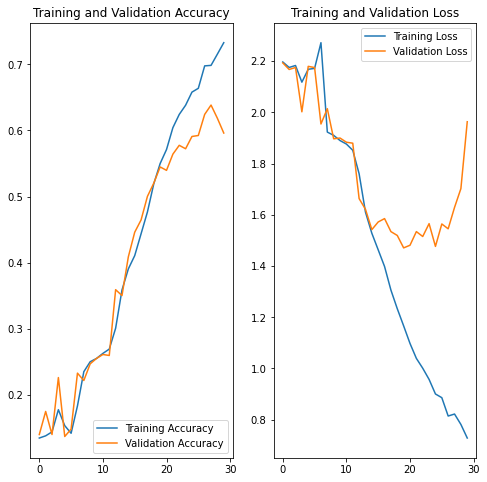

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [54]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

43/43 [==============================] - 6s 113ms/step - loss: 1.9634 - accuracy: 0.5961
Accuracy:  0.7429525256156921
Validation Accuracy:  0.5961395502090454
Loss:  0.7176012396812439
Validation Loss 1.963399052619934


Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

**Observations:**



1. Accuracy on training data has increased by using Augmentor library
2. Model is still overfitting
3. The problem of overfitting can be solved by add more layer,neurons or adding dropout layers.
4. The Model can be further improved by tuning the hyperparameter








